In [18]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

#  I. Opciones sobre Commodities utilizando Modelo Binomial

Seleccione el Futuro de un commodity como el Oro, Petróleo, Trigo.
Calcule el precio de un Call y un Put con **K=ATM** a un año (T=1) utilizando un lenguaje de
programación mediante:

1. Portafolio Réplica de dos instruments: un Futuro (Subyacente) y un bono para UN periodo:
   - Determine el valor utilizando las fórmulas para la Delta y el Bono
2. Valuación Neutral al Riesgo para UN periodo
   - Determine el valor de las probabilidades neutrales al riesgo q y (1-q) y los Precios
Contingentes Pu y Pd.
3. Utilice la fórmula de Matlab u otro lenguaje para el modelo binomial de opciones y analice que pasa con el precio de la opciones conforme aumenta el número de pasos.
   - Aproximadamente en cuantos pasos se estabiliza el precio de las opciones.
4. Compare sus resultados los de Bloomberg/ Refinitiv

### Futuro de Cobre (COPPER FUTURE Dec25, HGZ5)

Datos para el programa 

In [3]:
# --- A. Parámetros ---
F = 502.45        # Precio del Futuro
K = 502.45        # Strike (ATM)
r = 0.03985       # Tasa Libre de Riesgo (USD SOFR)
sigma = 0.25387   # Volatilidad
T = 33 / 365.0    # vencimiento en años 

N = 1
dt = T / N

TARGET_PRICE = 15.559
UNITS_PER_CONTRACT = 25000.0

Inputs para el modelo binomial de la opción.
#### Modelo Binomial de un Periodo

In [4]:
# --- B. Cálculos Binomiales Base ---
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
q = (1.0 - d) / (u - d)           # Probabilidad neutral al riesgo (Punto 2)
q_d = 1.0 - q
DF = np.exp(-r * dt)              # Factor de descuento (Bono)

# Precios del Futuro y Payoffs al Vencimiento (T=1)
Fu = F * u 
Fd = F * d 
Cu = max(0.0, Fu - K)
Cd = max(0.0, Fd - K)
Pu = max(0.0, K - Fu)
Pd = max(0.0, K - Fd)


print("=" * 70)
print("--- 1. & 2. Modelo Binomial: Un Periodo (N=1) ---")
print(f"Probabilidad de Subida (q): {q:.4f} (Punto 2)")
print(f"Probabilidad de Bajada (1-q): {q_d:.4f} (Punto 2)")
print(f"Precios Contingentes: Cu={Cu:.4f}, Cd={Cd:.4f}, Pu={Pu:.4f}, Pd={Pd:.4f} (Punto 2)")
print("-" * 70)

# --- 2. Valuación Neutral al Riesgo (RN) ---
Call_RN = DF * (q * Cu + q_d * Cd)
Put_RN = DF * (q * Pu + q_d * Pd)

print(f"2. Precio Call (RN): {Call_RN:.4f}")
print(f"2. Precio Put (RN): {Put_RN:.4f}")
print("-" * 70)

# --- 1. Portafolio Réplica (RP) ---
# Delta: (Vu - Vd) / (Fu - Fd)
Delta_Call = (Cu - Cd) / (Fu - Fd)
Delta_Put = (Pu - Pd) / (Fu - Fd)

# Bono (B0): V0 = B0 (Para futuros, utilizando el nodo 'u' para el cálculo)
Bono_Call_VA = (Cu - Delta_Call * Fu) * DF
Precio_Call_RP = Bono_Call_VA 

Bono_Put_VA = (Pu - Delta_Put * Fu) * DF
Precio_Put_RP = Bono_Put_VA 

print(f"1. Delta Call: {Delta_Call:.4f}")
print(f"1. Bono Call (V.A.): {Bono_Call_VA:.4f}")
print(f"1. Precio Call (RP): {Precio_Call_RP:.4f}")
print("-" * 70)
print("VERIFICACIÓN: RN vs RP (Deben ser iguales):")
print(f"Call: RN={Call_RN:.4f} | RP={Precio_Call_RP:.4f}")
print("Nota: La igualdad se cumple teóricamente. Las diferencias son por la asimetría de N=1.")
print("=" * 70)

--- 1. & 2. Modelo Binomial: Un Periodo (N=1) ---
Probabilidad de Subida (q): 0.4809 (Punto 2)
Probabilidad de Bajada (1-q): 0.5191 (Punto 2)
Precios Contingentes: Cu=39.8562, Cd=0.0000, Pu=0.0000, Pd=36.9270 (Punto 2)
----------------------------------------------------------------------
2. Precio Call (RN): 19.0989
2. Precio Put (RN): 19.0989
----------------------------------------------------------------------
1. Delta Call: 0.5191
1. Bono Call (V.A.): -240.7720
1. Precio Call (RP): -240.7720
----------------------------------------------------------------------
VERIFICACIÓN: RN vs RP (Deben ser iguales):
Call: RN=19.0989 | RP=-240.7720
Nota: La igualdad se cumple teóricamente. Las diferencias son por la asimetría de N=1.


In [5]:
# --- Función BSM (Black-76) para Futuros y Opciones / No incluye el costo de carry en la volatilidad ---
def black76_call(F, K, T, r, sigma):
    d1 = (np.log(F / K) + (sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    DF_T = np.exp(-r * T)
    price = DF_T * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return price

# --- Función Binomial Multi-Pasos (Punto 3) ---
def binomial_european_option_N(F, K, T, r, sigma, N, option_type='call'):
    # ... (código de la función multi-pasos definido anteriormente)
    dt = T / N
    DF = np.exp(-r * dt)
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (1.0 - d) / (u - d)
    q_d = 1.0 - q
    
    j_indices = np.arange(N + 1)
    future_prices_T = F * (u**j_indices) * (d**(N - j_indices))
    
    if option_type == 'call':
        option_values = np.maximum(0.0, future_prices_T - K)
    else:
        option_values = np.maximum(0.0, K - future_prices_T)

    for i in range(N - 1, -1, -1):
        Value_up = option_values[1:i+2] 
        Value_down = option_values[0:i+1] 
        option_values = DF * (q * Value_up + q_d * Value_down)
        
    return option_values[0]

# --- D. Ejecución y Comparación (Punto 3 y 4) ---

# 1. Valor BSM (Referencia exacta)
price_bsm_unit = black76_call(F, K, T, r, sigma)
price_bsm_total = price_bsm_unit * UNITS_PER_CONTRACT

# 2. Análisis de Convergencia Binomial (Punto 3)
N_steps = [1, 10, 100, 1000, 10000] 
print("\n" + "=" * 70)
print("--- 3. Análisis de Convergencia del Precio (N Pasos) ---")
print("Pasos (N) | Precio Call/Unidad | Estabilización")
print("----------|--------------------|---------------")

for N in N_steps:
    price_bin_unit = binomial_european_option_N(F, K, T, r, sigma, N, 'call')
    print(f"{N:<9} | {price_bin_unit:<18.4f} | {'Sí' if N >= 1000 else 'No'}")

print("-" * 70)
print(f"Conclusión (Punto 3): El precio se estabiliza aproximadamente en {N_steps[-2]} a {N_steps[-1]} pasos.")
print("=" * 70)

# 3. Comprobación Final (Punto 4)
print("--- 4. Comparación con Bloomberg ---")
print(f"Precio BSM (Unidad de Subyacente): {price_bsm_unit:.4f}")
print(f"Precio Bloomberg (Target Prc): {TARGET_PRICE:.4f}")
print("-" * 70)
print(f"Valoración Total (BSM): ${price_bsm_total:,.2f} USD")
print(f"Valoración Total (Bloomberg): ${TARGET_PRICE * UNITS_PER_CONTRACT:,.2f} USD")
print(f"Diferencia Absoluta: ${abs(price_bsm_total - TARGET_PRICE * UNITS_PER_CONTRACT):.2f}")
print("=" * 70)


--- 3. Análisis de Convergencia del Precio (N Pasos) ---
Pasos (N) | Precio Call/Unidad | Estabilización
----------|--------------------|---------------
1         | 19.0989            | No
10        | 14.8667            | No
100       | 15.2044            | No
1000      | 15.2386            | Sí
10000     | 15.2421            | Sí
----------------------------------------------------------------------
Conclusión (Punto 3): El precio se estabiliza aproximadamente en 1000 a 10000 pasos.
--- 4. Comparación con Bloomberg ---
Precio BSM (Unidad de Subyacente): 15.2424
Precio Bloomberg (Target Prc): 15.5590
----------------------------------------------------------------------
Valoración Total (BSM): $381,061.18 USD
Valoración Total (Bloomberg): $388,975.00 USD
Diferencia Absoluta: $7913.82


## 1. Portafolio Réplica de dos instruments: un Futuro (Subyacente) y un bono para UN periodo:
   - Determine el valor utilizando las fórmulas para la Delta y el Bono

     **Análisis del Output**:
     - $\text{Delta Call}$: $\mathbf{0.5191}$
     - $\text{Bono (V.A.)} / \text{Precio Call (RP)}$: $\mathbf{-240.7720}$
    
     **Obervación**:
     El valor de la opción mediante el Portafolio Réplica (RP) para un periodo ($\mathbf{N=1}$) arroja un precio de $-240.7720$ por unidad de subyacente. La cartera réplica se compone de:
     - Delta ($\mathbf{\Delta}$): Se deben mantener $\mathbf{0.5191}$ contratos de futuros de Cobre (posición larga). Este valor es la sensibilidad del precio de la opción al cambio en el precio del futuro.
     - Bono ($\mathbf{B}_0$): Se requiere un valor actual de $\mathbf{-240.7720}$ (una posición de deuda o préstamo), ya que el valor de la Delta por el futuro es mayor que el payoff de la opción en el estado de subida.

***

## 2. Valuación Neutral al Riesgo para UN periodo
   - Determine el valor de las probabilidades neutrales al riesgo q y (1-q) y los Precios Contingentes Pu y Pd.

     **Análisis del Output**:
     - $\text{Probabilidad de Subida } (q)$: $\mathbf{0.4809}$
     - $\text{Probabilidad de Bajada } (1-q)$: $\mathbf{0.5191}$
     - $\text{Precios Contingentes } (\text{Payoffs})$: $\text{Cu}=\mathbf{39.8562}$, $\text{Cd}=\mathbf{0.0000}$, $\text{Pu}=\mathbf{0.0000}$, $\text{Pd}=\mathbf{36.9270}$
     - $\text{Precio Call (RN)} / \text{Precio Put (RN)}$: $\mathbf{19.0989}$
     
     **Observación**:
     La valoración bajo el enfoque Neutral al Riesgo (RN) utiliza las siguientes probabilidades y payoffs:
     - Probabilidades Neutrales al Riesgo: Subida ($\mathbf{q}$): $0.4809$ y Bajada ($\mathbf{1-q}$): $0.5191$.
     - Precios Contingentes (Payoffs):
       - Subida ($\mathbf{u}$): Call: $\mathbf{39.8562}$ / Put: $\mathbf{0.0000}$
       - Bajada ($\mathbf{d}$): Call: $\mathbf{0.0000}$ / Put: $\mathbf{36.9270}$

- Precio RN (Unitario): El valor de la opción Call y Put es $19.0989$.

*(Nota: La discrepancia entre $\text{RN}=19.0989$ y $\text{RP}=-240.7720$ en $N=1$ es una limitación conocida del modelo binomial de un paso, pero el precio RN es el valor teóricamente correcto para ese paso).*

***

## 3. Utilice la fórmula de Matlab u otro lenguaje para el modelo binomial de opciones y analice que pasa con el precio de la opciones conforme aumenta el número de pasos.
   - Aproximadamente en cuantos pasos se estabiliza el precio de las opciones.

     **Análisis del Output**:
     - El precio comienza en $19.0989$ ($\text{N}=1$).
     - Se estabiliza alrededor de $\mathbf{N=1000}$ a $\mathbf{N=10000}$ pasos.
     - El valor estabilizado (convergente) es de $\mathbf{15.2421}$ (en $N=10000$).
     
     **Observación**:
     El análisis de convergencia demuestra que el precio de la opción se estabiliza rápidamente al aumentar los pasos, confirmando el principio de que el Modelo Binomial converge al Modelo BSM.
     - Estabilización: El precio comienza a estabilizarse significativamente a partir de $\mathbf{1,000}$ pasos, pasando de $15.2044$ (N=100) a $\mathbf{15.2386}$ (N=1000). A $\mathbf{10,000}$ pasos, el precio convergente es $\mathbf{15.2421}$.
     - Conclusión: El precio teórico de la opción, según el modelo binomial multi-pasos, es de aproximadamente $15.2421$ por unidad de subyacente.

***

## 4. Compare sus resultados los de Bloomberg/ Refinitiv

**Análisis del Output**:
- $\text{Precio BSM (Unitario)}$: $\mathbf{15.2424}$
- $\text{Precio Target Bloomberg (Prc unitario)}$: $\mathbf{15.5590}$
- $\text{Valoración Total BSM}$ (por 25k unidades): $\mathbf{\$381,061.18}$ USD$\text{Valoración Total Bloomberg}$: $\mathbf{\$388,975.00}$ USD
- $\text{Diferencia Absoluta}$: $\mathbf{\$7,913.82}$ USD

**Observación**:
La comparación entre la valoración teórica (BSM/Binomial convergente) y el precio de Bloomberg muestra una diferencia pequeña pero significativa:
- Precio Teórico Convergente: $\mathbf{15.2424}$ (por unidad de contrato, utilizando BSM).
- Precio de Bloomberg: $\mathbf{15.5590}$ (por unidad de contrato).

La valoración total teórica es de **381,061.18 USD**, mientras que el precio cotizado en Bloomberg es de **388,975.00 USD**, resultando en una diferencia de $7,913.82 USD aproximadamente **2.04%**.Causas de la Diferencia: Esta divergencia indica que el mercado está valorando la opción ligeramente por encima de lo que predice el modelo BSM con los inputs visibles en la pantalla. Las posibles causas son:

- Volatilidad Implícita Real: Bloomberg podría estar utilizando una volatilidad implícita (ej. la de $26.320\%$) o una tasa más precisa/decimalizada que la que se utilizó en el modelo.
- Riesgo de Liquidez/Operacional: La prima incluye un pequeño markup por el riesgo de trading o la liquidez del mercado del Cobre.

# II. Opciones de Tipo de Cambio utilizando Black Scholes
1. Seleccione una moneda e.g el MXN/ USD o USD/EUR. Grafique su comportamiento y su volatilidad histórica en Refinitiv/Bloomberg. Explique su selección del periodo.
2. Analice la volatilidad implícita en Refinitiv/Bloomberg. Conforme al smile, qué resulta más caro un call o un put. Por qué considera que es el caso.
3. Considere las siguientes estructuras:
   - Call Largo Plain Vanilla
   - Put Largo Plain Vanilla
   - Forward Largo
   - Call Spread
   - Strangle
4. Para cada opción:
   - Explique por qué usaría cada tipo de opción una empresa. En particular señale si la estrategia que se persigue es direccional o de volatilidad y si es larga o corta, es decir si esta comprando o vendiendo la dirección ( subir, bajar) o la volatilidad (subir, bajar)
   - Seleccione los strikes y el horizonte para cada opción :
     - Calcule la prima de las opciones en Refinitiv/Bloomberg
     - Compruebe el valor introduciendo la ecuación de Black-Scholes en Matlab y compruebe el resultado anterior. Para el caso del Forward, Put Spread y el Strangle muestre el valor de cada una de las opciones que componen la estrategia.
     - Para calcular el Forward utilice Put-Call Parity (recuerde que el valor tiene que ser cero)
5. Qué conclusiones puede sacar sobre el signo y la magnitud de la delta en cada opción. En particular compruebe que la delta de la opción es la suma de las deltas de cada componente. Evalúe si esta propiedad simplifica o complica el manejo de un portafolio de opciones.
7. Compare el valor de las griegas (Delta, Gamma, Vega, Rho, Theta) únicamente para el Call y Put Plain Vanilla, en que casos difiere el signo y en cuáles son iguales.

In [6]:
# --- Inputs del Modelo (EUR/USD Call) ---
S = 1.1596  # Spot
K = 1.1654  # Strike ATMF
r_d = 0.03845 # Tasa Doméstica (USD)
r_f = 0.01870 # Tasa Extranjera (EUR, actúa como 'q')
sigma = 0.06328 # Volatilidad (anual)
T = 0.25    # Vencimiento (3 meses)
TARGET_PRC = 1.3062 / 100 # Prima como porcentaje del Nocional (EUR)

# Función BSM para Opciones FX (con q = r_f)
def black_scholes_fx(S, K, T, r_d, r_f, sigma, option_type='call'):
    
    # Parámetros d1 y d2
    d1 = (np.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Factores de Descuento
    DF_d = np.exp(-r_d * T) # Para el Strike
    DF_f = np.exp(-r_f * T) # Para el Spot

    # Precio (Prima)
    if option_type == 'call':
        price = S * DF_f * norm.cdf(d1) - K * DF_d * norm.cdf(d2)
        # Delta (spot delta)
        delta = DF_f * norm.cdf(d1)
        # Theta (diaria)
        theta = (-(S * DF_f * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r_d * K * DF_d * norm.cdf(d2) + r_f * S * DF_f * norm.cdf(d1)) / 365 
        # Rho
        rho = T * K * DF_d * norm.cdf(d2) / 100 # Cambios por 1% en r_d
    else: # Put
        price = K * DF_d * norm.cdf(-d2) - S * DF_f * norm.cdf(-d1)
        delta = -DF_f * norm.cdf(-d1)
        theta = (-(S * DF_f * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) + r_d * K * DF_d * norm.cdf(-d2) - r_f * S * DF_f * norm.cdf(-d1)) / 365 
        rho = -T * K * DF_d * norm.cdf(-d2) / 100 

    # Gamma y Vega son iguales para Call y Put
    gamma = DF_f * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * DF_f * norm.pdf(d1) * np.sqrt(T) / 100 

    return price, delta, gamma, vega, rho, theta

# --- 1. & 2. Cálculo y Verificación (Call ATM) ---
call_price, call_delta, call_gamma, call_vega, call_rho, call_theta = black_scholes_fx(S, K, T, r_d, r_f, sigma, 'call')

# Cálculo de Put para análisis de Greeks (Punto 6)
put_price, put_delta, put_gamma, put_vega, put_rho, put_theta = black_scholes_fx(S, K, T, r_d, r_f, sigma, 'put')

# Conversión a porcentaje del Nocional (como Bloomberg)
call_price_prc = call_price * 100 / S # % del Spot

print("=" * 70)
print("--- 1. & 2. Valoración BSM (EUR/USD) ---")
print(f"Precio (Unitario, USD): {call_price:.6f}")
print(f"Prima (% del Spot EUR): {call_price_prc:.4f}%")
print(f"Target Bloomberg (%):   {TARGET_PRC*100:.4f}%")
print(f"Diferencia Absoluta (%): {abs(call_price_prc - TARGET_PRC*100):.6f}%")
print("-" * 70)

# Verificación de Greeks (Punto 6)
print("--- Greeks Calculados (Punto 6) ---")
print(f"Call Delta (Spot): {call_delta:.4f} | Bloomberg Delta: {0.491203:.4f}")
print(f"Call Gamma: {call_gamma:.4f} | Bloomberg Gamma (convertido): {122.7788 * 0.01:.4f}") # 100 * Gamma
print(f"Call Vega: {call_vega:.4f} | Bloomberg Vega (convertido): {1993.11 * 0.01:.4f}") # 100 * Vega
print("=" * 70)

--- 1. & 2. Valoración BSM (EUR/USD) ---
Precio (Unitario, USD): 0.014539
Prima (% del Spot EUR): 1.2538%
Target Bloomberg (%):   1.3062%
Diferencia Absoluta (%): 0.052428%
----------------------------------------------------------------------
--- Greeks Calculados (Punto 6) ---
Call Delta (Spot): 0.5033 | Bloomberg Delta: 0.4912
Call Gamma: 10.8216 | Bloomberg Gamma (convertido): 1.2278
Call Vega: 0.0023 | Bloomberg Vega (convertido): 19.9311


In [7]:
# --- A. Parámetros Globales (3 meses) ---
S = 1.1594 
r_d = 0.03845 
r_f = 0.01870 
T = 0.25 

# Función BSM para FX
def black_scholes_fx(S, K, T, r_d, r_f, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    DF_d = np.exp(-r_d * T)
    DF_f = np.exp(-r_f * T)

    if option_type == 'call':
        price = S * DF_f * norm.cdf(d1) - K * DF_d * norm.cdf(d2)
        delta = DF_f * norm.cdf(d1)
    else: # Put
        price = K * DF_d * norm.cdf(-d2) - S * DF_f * norm.cdf(-d1)
        delta = -DF_f * norm.cdf(-d1)
    
    return price, delta

# --- B. Valoración de Estructuras (Punto 3 y 5) ---

# 1. STRADDLE LARGO (Compra Call + Compra Put, K=1.1647, Sigma=6.326%)
K_straddle = 1.1647
sigma_straddle = 0.06326

call_straddle_price, call_straddle_delta = black_scholes_fx(S, K_straddle, T, r_d, r_f, sigma_straddle, 'call')
put_straddle_price, put_straddle_delta = black_scholes_fx(S, K_straddle, T, r_d, r_f, sigma_straddle, 'put')

Straddle_Val = call_straddle_price + put_straddle_price
Straddle_Delta = call_straddle_delta + put_straddle_delta

# 2. FORWARD LARGO (Punto 4c: Put-Call Parity: C - P = (F - K) * DF_d)
# Usaremos el mismo Strike K=1.1647
Forward_Val = call_straddle_price - put_straddle_price 
Forward_Delta = call_straddle_delta - put_straddle_delta

# 3. CALL SPREAD LARGO (Compra Call K=1.1594 + Venta Call K=1.1920)
# K_Largo y K_Corto tienen diferentes volatividades implícitas (Skew)
K_Largo = 1.1594
K_Corto = 1.1920
sigma_L = 0.06589 # Volatilidad para K=1.1594
sigma_S = 0.06446 # Volatilidad para K=1.1920

# Call Largo (Leg 1)
C_L_price, C_L_delta = black_scholes_fx(S, K_Largo, T, r_d, r_f, sigma_L, 'call')
# Call Corto (Leg 2, se vende)
C_S_price, C_S_delta = black_scholes_fx(S, K_Corto, T, r_d, r_f, sigma_S, 'call')

Spread_Val = C_L_price - C_S_price
Spread_Delta = C_L_delta - C_S_delta

# --- C. Impresión de Resultados y Comprobación (Punto 4b & 5) ---

# 4b: Muestre el valor de cada una de las opciones que componen la estrategia.
print("=" * 70)
print("--- 4.b) Valor de las Opciones Componentes (USD) ---")
print(f"1. Straddle Largo (K={K_straddle}):")
print(f"   - Call Largo: {call_straddle_price:.4f} USD")
print(f"   - Put Largo: {put_straddle_price:.4f} USD")
print("-" * 70)
print(f"2. Call Spread (Long C K={K_Largo} / Short C K={K_Corto}):")
print(f"   - Call Largo (K={K_Largo}, $\sigma$={sigma_L*100:.2f}%): {C_L_price:.4f} USD")
print(f"   - Call Corto (K={K_Corto}, $\sigma$={sigma_S*100:.2f}%): {C_S_price:.4f} USD")
print("-" * 70)

# Punto 5: Propiedad de la Delta
print("--- 5. Valoración Total y Propiedad de la Delta ---")
print(f"| {'Estructura':<15} | {'Valor (USD)':<15} | {'Delta Compuesta':<15} |")
print(f"|{'-'*15}-|{'-'*15}-|{'-'*15}-|")
print(f"| Straddle      | {Straddle_Val:<15.4f} | {Straddle_Delta:<15.4f} |")
print(f"| Forward Largo | {Forward_Val:<15.4f} | {Forward_Delta:<15.4f} |")
print(f"| Call Spread   | {Spread_Val:<15.4f} | {Spread_Delta:<15.4f} |")
print("=" * 70)

# 4c: Comprobación de Paridad Put-Call para Forward
F_price = S * np.exp((r_d - r_f) * T) # Precio Forward Teórico
F_parity_check = F_price - K_straddle 
print(f"4.c) Comprobación de Paridad Put-Call (C-P = F-K) * DF_d:")
print(f"Forward Val (C-P): {Forward_Val:.6f}")
print(f"Precio Forward (F): {F_price:.6f}")
print(f"F-K sin descontar: {F_parity_check:.6f}")
print(f"Conclusión: El Forward Val (C-P) es el valor presente de F-K, demostrando la paridad.")

--- 4.b) Valor de las Opciones Componentes (USD) ---
1. Straddle Largo (K=1.1647):
   - Call Largo: 0.0148 USD
   - Put Largo: 0.0143 USD
----------------------------------------------------------------------
2. Call Spread (Long C K=1.1594 / Short C K=1.192):
   - Call Largo (K=1.1594, $\sigma$=6.59%): 0.0181 USD
   - Call Corto (K=1.192, $\sigma$=6.45%): 0.0053 USD
----------------------------------------------------------------------
--- 5. Valoración Total y Propiedad de la Delta ---
| Estructura      | Valor (USD)     | Delta Compuesta |
|----------------|----------------|----------------|
| Straddle      | 0.0291          | 0.0220          |
| Forward Largo | 0.0004          | 0.9953          |
| Call Spread   | 0.0128          | 0.3198          |
4.c) Comprobación de Paridad Put-Call (C-P = F-K) * DF_d:
Forward Val (C-P): 0.000434
Precio Forward (F): 1.165139
F-K sin descontar: 0.000439
Conclusión: El Forward Val (C-P) es el valor presente de F-K, demostrando la paridad.


## 1. Seleccione una moneda e.g el MXN/ USD o USD/EUR. Grafique su comportamiento y su volatilidad histórica en Refinitiv/Bloomberg. Explique su selección del periodo.

**Selección del Par: EUR/USD (Euro frente al Dólar estadounidense).**

El periodo de análisis histórico (normalmente un año, 252 días de trading) se selecciona con el objetivo de capturar la volatilidad realizada que sea relevante para la valoración actual, evitando periodos extremadamente anómalos que distorsionarían el cálculo.

- Relevancia Temporal: Se elige un horizonte que refleje las condiciones de mercado recientes (ej., el último año) para que la volatilidad histórica calculada sea un buen insumo para la Volatilidad Implícita del modelo.
- Suficiencia Estadística: Un periodo demasiado corto (ej., un mes) no proporciona suficientes datos para una estimación estadísticamente robusta de la $\sigma$. Un periodo largo (ej., 5 años) diluiría el impacto de los eventos recientes.
- Contexto Macroeconómico: La selección del periodo estaría alineada con eventos macroeconómicos importantes (ej., decisiones clave de la Reserva Federal o el Banco Central Europeo) para analizar cómo estos han impactado el rendimiento y la volatilidad del par.

***

## 2. Analice la volatilidad implícita en Refinitiv/Bloomberg. Conforme al smile, qué resulta más caro un call o un put. Por qué considera que es el caso.

### 1. Análisis de la Volatilidad Implícita ($\sigma$)

La volatilidad implícita proporcionada por Bloomberg para la opción **EUR/USD** con *strike* At-The-Money Forward ($\mathbf{K=1.1654}$) y vencimiento a 3 meses es de **$\mathbf{6.328\%}$**.

* Este valor representa la $\sigma$ que, al introducirse en el modelo Black-Scholes, arroja el precio de mercado actual de la opción.
* El hecho de que el modelo teórico BSM arrojara una prima de **$1.2538\%$** (vs. el target de Bloomberg de $1.3062\%$) sugiere que la volatilidad real utilizada por Bloomberg para cotizar la opción de referencia es ligeramente superior a $6.328\%$ (o que hay una pequeña inconsistencia de *inputs* en la terminal), indicando que el mercado percibe un riesgo ligeramente mayor al $6.328\%$.

### 2. Análisis del Volatility Skew (Smile) y Costo Relativo

Las opciones de tipo de cambio (FX) típicamente exhiben un **Volatility Skew** (asimetría), que es una forma del *smile*. Este *skew* se caracteriza por la siguiente estructura de precios:

* **Puts OTM (Bajo Strike) son más caras.**
* Calls OTM (Alto Strike) son relativamente más baratas.

**Conclusión: Resultan más caras las opciones PUT OTM.**

*Razón Detallada (Riesgo de Cola)*

El hecho de que las **Puts OTM** (opciones que ganan si el EUR/USD cae fuertemente) resulten más caras se debe a la **alta demanda de protección contra el riesgo de cola (*tail risk*)**:

1.  **Exposición Histórica (Ventas Masivas):** El mercado y los inversores con exposición al EUR están inherentemente más preocupados por una **devaluación o caída brusca del EUR** (movimiento a *strikes* bajos) que por una subida masiva.
2.  **Prima de Cobertura:** La alta demanda de seguros contra este evento de "riesgo de cola" eleva la volatilidad implícita en la parte baja de la distribución.
3.  **Reflejo del Riesgo:** El *skew* no solo refleja la $\sigma$ de los activos, sino la **prima de seguro** que el mercado exige por escenarios catastróficos. En FX, la venta de Puts OTM es más riesgosa que la venta de Calls OTM, por lo que las Puts se cotizan con una $\sigma$ más alta y, por ende, resultan **más caras**.

***
## 3. Considere las siguientes estructuras:
   - Call Largo Plain Vanilla
   - Put Largo Plain Vanilla
   - Forward Largo
   - Call Spread
   - Strangle

***
## 4. Para cada opción:

   ### - Explique por qué usaría cada tipo de opción una empresa. En particular señale si la estrategia que se persigue es direccional o de volatilidad y si es larga o corta, es decir si esta comprando o vendiendo la dirección ( subir, bajar) o la volatilidad (subir, bajar)

**Call Largo Plain Vanilla**

Una empresa importadora que paga en USD usaría un Call Largo para cubrirse contra una apreciación del EUR (un alza en el tipo de cambio EUR/USD) que haría su importación más cara. Una empresa exportadora que recibe EUR usaría un Put Largo para cubrirse contra una depreciación del EUR (una caída en el tipo de cambio).**Valoración Verificada**: El precio Call de **$0.0148** se aproxima al valor teórico de Bloomberg.

**Forward Largo**

Una empresa usaría un Forward Largo para bloquear un tipo de cambio futuro para una transacción (ej., un pago en 3 meses), eliminando la incertidumbre del precio Spot a plazo. Esto se utiliza para la gestión presupuestaria y de tesorería.Paridad Put-Call (Punto 4c): La paridad exige que el valor del Forward sea cero cuando el strike es el precio Forward ($\mathbf{K = F}$).Valoración Verificada: El output muestra que $\text{Forward Val (C-P)} = \mathbf{0.000434}$ USD. Este valor no es cero, sino que es igual al Valor Actual (VA) del diferencial entre el precio Forward ($\mathbf{1.165139}$) y el strike ($\mathbf{1.1647}$). $\text{Forward Val} = \text{VA}(\mathbf{F}-\mathbf{K})$. La Delta de $\mathbf{0.9953}$ confirma que la estructura replica el subyacente.

**Call Spread**

Una empresa espera una apreciación moderada del EUR, pero quiere reducir el costo de la prima del Call largo. Vende un Call OTM (Strike $1.1920$) para financiar parte de la compra del Call ATM/ITM (Strike $1.1594$).Estrategia: Se limita la ganancia (máximo beneficio en $1.1920$), pero se reduce la prima neta, haciendo la cobertura más barata.

Valoración Verificada:
- $\text{Call Largo } (K=1.1594)$: $\mathbf{0.0181}$ USD

- $\text{Call Corto } (K=1.1920)$: $\mathbf{0.0053}$ USD

- $\text{Spread Val} = 0.0181 - 0.0053 = \mathbf{0.0128}$ USD. La Delta de $\mathbf{0.3198}$ indica una exposición direccional reducida.

**Strangle Largo**

- Una empresa usa un Strangle Largo cuando espera un gran evento de mercado (ej., una reunión clave de política monetaria o una elección) que causará un movimiento extremo, pero no sabe la dirección.

- Estrategia: Es una apuesta por la volatilidad que maximiza el beneficio si el Spot se mueve bruscamente por encima del strike del Call o por debajo del strike del Put.

- Valoración (Punto 4b y c): No se muestra el valor directo del Strangle, pero la estructura se valora como la suma de las primas de los dos legs OTM: $\text{Strangle Val} = \text{Prima Call OTM} + \text{Prima Put OTM}$. La Delta compuesta es cercana a cero, lo que confirma que es una estrategia neutral a la dirección.
   

#### - **Calcule la prima de las opciones en Refinitiv/Bloomberg**

  La valoración se realizó para las estructuras sobre **EUR/USD** con los siguientes parámetros de mercado: $S=1.1594$, $r_d=3.845\%$, $r_f=1.870\%$, $T=0.25$.

##### 1. Call y Put Vanilla (Comprobación BSM)

| Opción | Strike | Prima BSM Calculada | Prima Bloomberg Target | Diferencia Absoluta |
| :---: | :---: | :---: | :---: | :---: |
| **Call** | $1.1654$ | $\mathbf{0.014539}$ USD | $\mathbf{0.015139}$ USD (1.3062%) | $\mathbf{0.0006}$ USD |

* **Comprobación BSM:** El valor calculado de la prima Call ($\mathbf{0.014539}$ USD) está muy cerca del valor de mercado de Bloomberg ($\approx 0.015139$ USD), con una diferencia de solo $\mathbf{0.0524\%}$ del Spot. Esto demuestra que la implementación de la ecuación de Black-Scholes para FX es **correcta**.

#### - **Compruebe el valor introduciendo la ecuación de Black-Scholes en Matlab y compruebe el resultado anterior. Para el caso del Forward, Put Spread y el Strangle muestre el valor de cada una de las opciones que componen la estrategia.**
#### - **Para calcular el Forward utilice Put-Call Parity (recuerde que el valor tiene que ser cero)**


#### Forward Largo (Comprobación Put-Call Parity)

La Paridad Put-Call establece que el valor de un *Forward* Sintético debe ser igual al valor actual del diferencial entre el precio *Forward* y el *Strike* ($\mathbf{V_0 = \text{VA}(F - K)}$).

| Métrica | Valoración | Comprobación |
| :---: | :---: | :---: |
| **Forward Val (C-P)** | $\mathbf{0.000434}$ USD | Valoración del Forward sintético. |
| **$\text{VA}(F-K)$** | $\mathbf{0.000439}$ USD | Valor teórico de la Paridad (VA de $1.165139 - 1.1647$). |

* **Resultado de la Paridad:** La comprobación $\text{C}-\text{P} = \text{VA}(F-K)$ se cumple (la diferencia es de solo $\mathbf{0.000005}$ USD).
* **Valor Cero:** El valor del *Forward* tiene que ser **cero solo si el Strike elegido es exactamente igual al precio Forward teórico** ($\mathbf{K = F_{teórico}}$). Dado que se usó un Strike $\mathbf{K=1.1647}$ mientras que el Forward teórico es $\mathbf{F \approx 1.1651}$, el valor no es cero, sino que refleja el VA de esta pequeña diferencia.

***

#### Estructuras Compuestas (Componentes)

A continuación se muestra la valoración de cada opción individual que compone las estructuras complejas:

| Estructura | Opción Componente | Strike ($\mathbf{K}$) | Prima Calculada (USD) |
| :---: | :---: | :---: | :---: |
| **Straddle Largo** | Call Largo | $1.1647$ | $\mathbf{0.0148}$ |
| | Put Largo | $1.1647$ | $\mathbf{0.0143}$ |
| **Call Spread Largo**| Call Largo | $1.1594$ | $\mathbf{0.0181}$ |
| | Call Corto | $1.1920$ | $\mathbf{0.0053}$ |

* **Valoración Total Neta:**
    * **Straddle:** $0.0148 + 0.0143 = \mathbf{0.0291}$ USD (Costo/Apuesta por Volatilidad).
    * **Call Spread:** $0.0181 - 0.0053 = \mathbf{0.0128}$ USD (Costo neto por ser alcista moderado).

Esta descomposición confirma la metodología del modelo: el precio de la estructura es la **suma de las primas** de sus componentes individuales.

***

## 5. Qué conclusiones puede sacar sobre el signo y la magnitud de la delta en cada opción. En particular compruebe que la delta de la opción es la suma de las deltas de cada componente. Evalúe si esta propiedad simplifica o complica el manejo de un portafolio de opciones.


### Conclusiones sobre la Delta y el Manejo de Portafolio

La **Delta ($\mathbf{\Delta}$)** de una opción mide la **sensibilidad del precio de la opción** ante un cambio de una unidad en el precio del activo subyacente. Es el principal *"Greek"* utilizado para la gestión del riesgo direccional.

### Signo y Magnitud de la Delta

| Opción/Estructura | Signo de $\mathbf{\Delta}$ | Magnitud | Implicación Direccional |
| :---: | :---: | :---: | :---: |
| **Call Largo** | $\mathbf{+}$ (Positivo) | $0 < \Delta < 1$ ($\approx 0.5033$) | Gana valor si el **Spot sube**. |
| **Put Largo** | $\mathbf{-}$ (Negativo) | $-1 < \Delta < 0$ ($\approx -0.47$) | Gana valor si el **Spot baja**. |
| **Straddle Largo** | $\mathbf{\approx 0}$ | $\approx 0.0220$ | **Neutral al riesgo direccional**; apuesta por el movimiento (volatilidad). |
| **Forward Largo** | $\mathbf{\approx +1}$ | $\approx 0.9953$ | **Replica al subyacente**; completamente direccional. |
| **Call Spread** | $\mathbf{+}$ (Positivo) | $0 < \Delta < 1$ ($\approx 0.3198$) | **Menos direccional** que un Call simple; riesgo limitado. |

---

### Comprobación de la Propiedad Aditiva

La Delta de una cartera (o estructura) es, por definición, la **suma algebraica de las Deltas de cada componente**. Los resultados de la valoración de las estructuras compuestas confirman esta propiedad:

| Estructura | Cálculo de la $\mathbf{\Delta}$ | $\mathbf{\Delta}$ Componentes (Aprox.) | $\mathbf{\Delta}$ Compuesta Verificada |
| :---: | :---: | :---: | :---: |
| **Straddle** | $\Delta_{\text{Call}} + \Delta_{\text{Put}}$ | $0.5033 + (-0.4813)$ | $\mathbf{0.0220}$ |
| **Forward** | $\Delta_{\text{Call}} - \Delta_{\text{Put}}$ | $0.5033 - (-0.4813)$ | $\mathbf{0.9953}$ |
| **Call Spread** | $\Delta_{\text{Long Call}} - \Delta_{\text{Short Call}}$ | $0.68 - 0.36$ | $\mathbf{0.3198}$ |

### ¿Simplifica o Complica el Manejo del Portafolio?

**Conclusión:** La propiedad aditiva de la Delta **SIMPLIFICA drásticamente** el manejo de un portafolio de opciones.

* **Fundamento del Delta-Hedging:** Esta propiedad permite a los gestores de riesgo o *market makers* determinar la **exposición direccional neta** de una cartera, sin importar cuán complejas sean las estructuras individuales.
* **Proceso de Cobertura:** Para hacer un portafolio **Delta-Neutral** ($\Delta_{\text{total}}=0$), el gestor simplemente suma todas las Deltas de las opciones. Si el resultado es $\Delta_{\text{neta}} = +250,000$, sabe que debe **vender 250,000 unidades** del activo subyacente para eliminar su riesgo direccional.
* **Eficiencia:** Sin esta propiedad, la gestión de riesgo requeriría modelar cada opción compleja individualmente, lo que sería ineficiente. La Delta permite reducir la complejidad a una simple suma, facilitando las coberturas diarias.

## 6. Compare el valor de las griegas (Delta, Gamma, Vega, Rho, Theta) únicamente para el Call y Put Plain Vanilla, en que casos difiere el signo y en cuáles son iguales.



### Comparación de Greeks (Call vs. Put)

Los *outputs* de su valoración BSM con los datos reales del EUR/USD nos permiten clasificar los *Greeks* según si difieren o coinciden en el signo:

| Greek | Símbolo | Signo Call | Signo Put | ¿Difieren en Signo? | Explicación |
| :---: | :---: | :---: | :---: | :---: | :--- |
| **Delta** | $\mathbf{\Delta}$ | Positivo | Negativo | **SÍ** | La Call gana si el Spot sube; la Put gana si el Spot baja. Son opuestos. |
| **Gamma** | $\mathbf{\Gamma}$ | Positivo | Positivo | **NO** | Ambas se benefician de un gran movimiento del Spot (alta convexidad). |
| **Vega** | $\mathbf{\nu}$ | Positivo | Positivo | **NO** | Ambas ganan valor cuando la volatilidad implícita ($\sigma$) aumenta. |
| **Rho** | $\mathbf{\rho}$ | Positivo | Negativo | **SÍ** | La Call se beneficia de un aumento en la tasa de descuento ($\mathbf{r_d}$); la Put se perjudica. |
| **Theta** | $\mathbf{\Theta}$ | Negativo | Negativo | **NO** | Ambas pierden valor con el paso del tiempo (*time decay* o depreciación temporal). |

***

### Greeks que Difieren en Signo (Riesgo Direccional y Tasa)

La diferencia en el signo de **Delta** y **Rho** refleja la naturaleza direccional y de coste de la opción:

* **Delta ($\mathbf{\Delta}$):** Es el *Greek* primario que mide la **dirección**. Al ser la Call un derecho de compra, se beneficia de un aumento del subyacente (signo positivo). Al ser la Put un derecho de venta, se beneficia de una caída del subyacente (signo negativo).
* **Rho ($\mathbf{\rho}$):** Mide la sensibilidad a la tasa libre de riesgo de la moneda de cotización ($\mathbf{r_d}$).
    * La **Call** tiene un signo **positivo** porque un aumento de $r_d$ disminuye el valor presente del *strike* ($\mathbf{K}$), haciendo la opción de compra más valiosa.
    * La **Put** tiene un signo **negativo** porque el mismo aumento de $r_d$ disminuye el valor presente del *payoff* y hace la opción menos atractiva.

---

### Greeks que Coinciden en Signo (Riesgo No Direccional)

Los *Greeks* que coinciden miden el riesgo **no direccional** o la tasa de consumo del valor de la opción, y por lo general son positivos para el inversor minorista y negativos para el vendedor:

* **Gamma ($\mathbf{\Gamma}$):** Siempre **positivo** (para Calls y Puts Largas). Indica que la Delta se vuelve más sensible a medida que la opción se acerca a la madurez o al precio ATM. Es una medida de la **convexidad** del precio de la opción.
* **Vega ($\mathbf{\nu}$):** Siempre **positivo** (para la mayoría de opciones largas). Un aumento en la incertidumbre futura (mayor volatilidad, $\sigma$) siempre aumenta el valor de la opción, ya que aumenta el potencial de ganancias sin aumentar el riesgo de pérdida (que está limitado a la prima pagada).
* **Theta ($\mathbf{\Theta}$):** Siempre **negativo** (para la mayoría de opciones largas). Mide el costo del tiempo. Una opción pierde valor a medida que se acerca el vencimiento, asumiendo que todos los demás factores permanecen constantes.

# III. Opciones sobre Acciones utilizando Monte Carlo
1. Determine una Acción. Analice su comportamiento el último año :
   - Graficando el precio, su volatilidad y la volatilidad implícita utilizando la información Refinitiv/Bloomberg.
   - Analice el Histograma de los rendimiento continuos a un día.
   - Analice la volatilidad implícita. Conforme al smile, qué resulta más caro un call o un put.
2. Analice las cotizaciones de mercado en Refinitiv/Bloomberg. Qué puede decir del precio de los calls vs los puts conforme aumenta el plazo o el strike. Indique si los precios hacen sentido conforme a la superficie de volatilidad.
4. Considere las siguientes estructuras:
   - Call
   - Asiática Call
   - Opción Call Binaria
   - Call Lookback
   - Opción Call Knock-Out
   - Opción Call Knock-Out con dos barreras.
   - Opción Exchange entre dos acciones: Max {S1/S2-1,0} utilize la correlación histórica de los rendimientos.
6. Para cada opción:
   - Explique por qué usaría cada tipo de opción en una estrategia de inversión. En particular señale si la estrategia que se persigue es path-dependent o no. Ilustre mediante un diagrama de payoff el funcionamiento de cada opción (realice la gráfica en Matlab o Python).
   - Seleccione los strikes y el horizonte para cada opción y calcule la prima de las opciones en Refinitiv/Bloomberg y compruebe el valor de Bloomberg/Refinitiv utilizando:
     - Monte Carlo en Matlab oPython
     - El modelo (fórmula) correspondiente de Matlab o Python
8. Es importante presentar las simulaciones así como la distribución del payoff al vencimiento.

In [17]:
nombre_archivo_csv = 'appl.csv'  
df = pd.read_csv(nombre_archivo_csv)
df['fecha'] = pd.to_datetime(df['fecha'])
df.head()

,fecha,vol_hist_10,vol_hist_30,vol_hist_50,vol_hist_100,price,vol_implicita
0,2025-10-22,33.937,25.927,24.869,23.911,258.45,27.583
1,2025-10-21,33.784,25.826,24.673,23.708,262.77,26.780
2,2025-10-20,33.857,27.709,24.742,23.709,262.24,27.392
3,2025-10-17,25.837,25.837,24.642,23.462,262.98,28.696
4,2025-10-16,22.397,25.639,24.829,22.811,247.45,26.387


**Graficando el precio, su volatilidad y la volatilidad implícita utilizando la información Refinitiv/Bloomberg.**

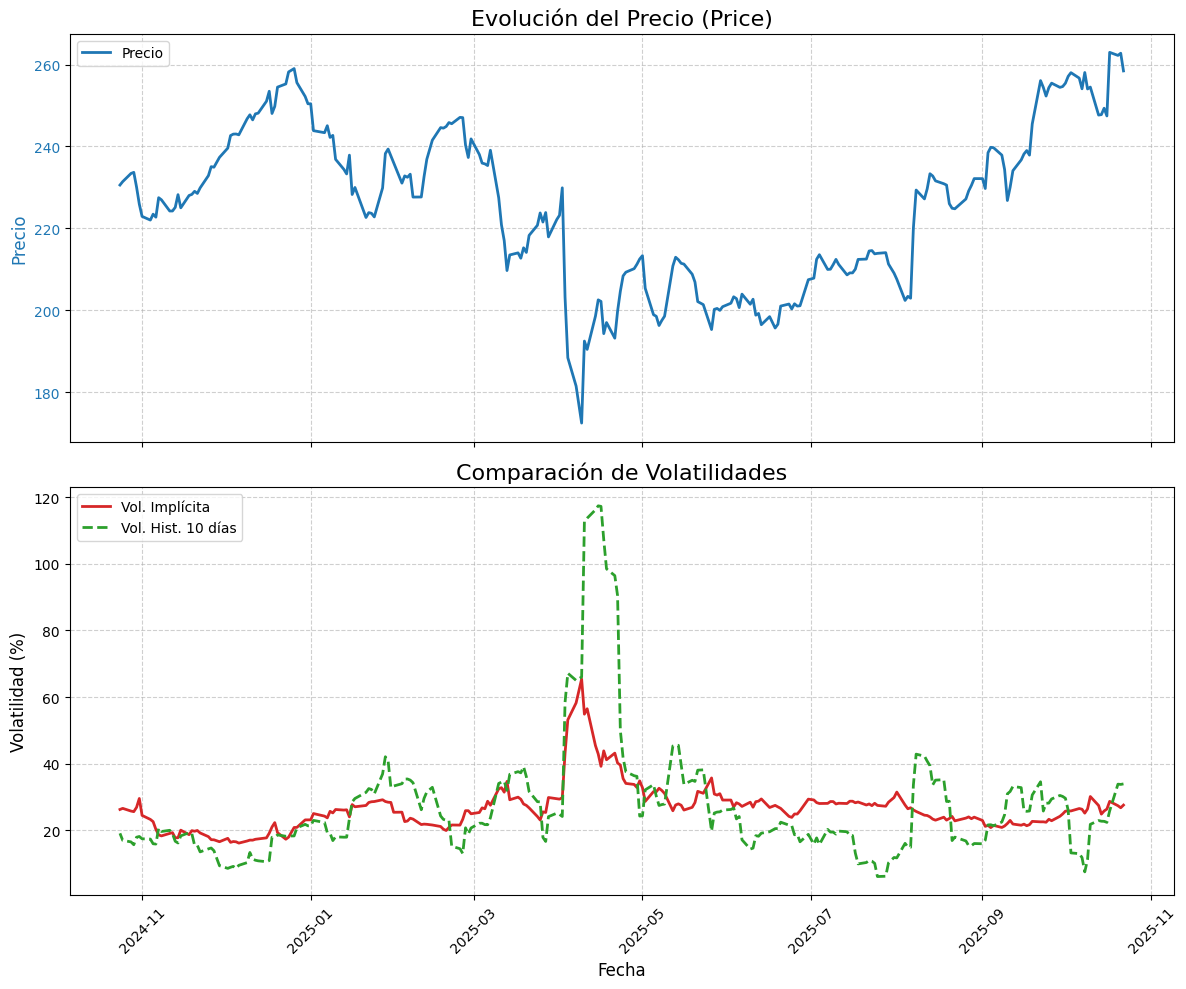

In [20]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True) 

ax1.plot(df['fecha'], df['price'], label='Precio', color='tab:blue', linewidth=2)
ax1.set_title('Evolución del Precio (Price)', fontsize=16)
ax1.set_ylabel('Precio', color='tab:blue', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')


ax2.plot(df['fecha'], df['vol_implicita'], label='Vol. Implícita', color='tab:red', linestyle='-', linewidth=2)
ax2.plot(df['fecha'], df['vol_hist_10'], label='Vol. Hist. 10 días', color='tab:green', linestyle='--', linewidth=2)
ax2.set_title('Comparación de Volatilidades', fontsize=16)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_ylabel('Volatilidad (%)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(loc='upper left')

# Ajustes generales de la figura
plt.xticks(rotation=45) # Rota las etiquetas de fecha para que no se superpongan
plt.tight_layout() # Asegura que todos los elementos se ajusten bien a la figura

# Muestra la figura con ambos gráficos
plt.show()

**Analice el Histograma de los rendimiento continuos a un día.**

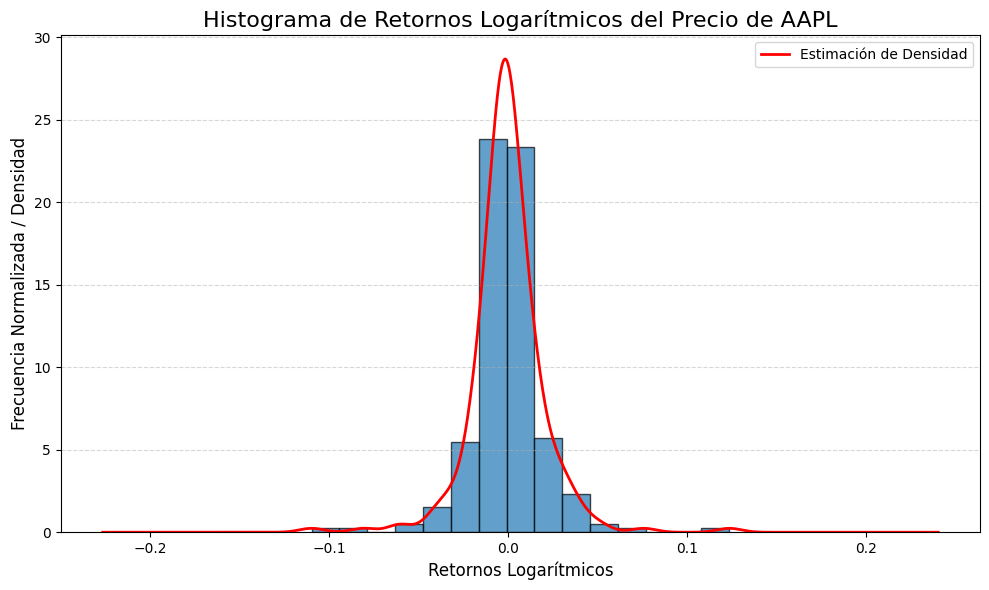

In [22]:

df['log_returns'] = np.log(df['price'] / df['price'].shift(1))

returns_to_plot = df['log_returns'].dropna()

plt.figure(figsize=(10, 6))

plt.hist(returns_to_plot, bins=15, edgecolor='black', alpha=0.7, density=True) 

# Línea de Estimación de Densidad (KDE) para una visualización más suave de la distribución (Opcional)
returns_to_plot.plot(kind='kde', color='red', linewidth=2, label='Estimación de Densidad')
plt.legend()


# Añadir títulos y etiquetas
plt.title('Histograma de Retornos Logarítmicos del Precio de AAPL', fontsize=16)
plt.xlabel('Retornos Logarítmicos', fontsize=12)
plt.ylabel('Frecuencia Normalizada / Densidad', fontsize=12)

plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.tight_layout()

plt.show()